In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt  
import seaborn as sns
import random
import json
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

'''Parameters of training/evaluation data '''
xi=0.1                              # Exploration-Exploitation trade of coefficient sigma for PI and EI acquisition Function
kappa=2.576                         # Exploration-Exploitation trade of coefficient sigma for PI and UBC acquisition Function
iteration = 50                      # Number of episodes for each trajectories
ds_num = 10                         # Number of trajectories, refering N*M in the report
f_num = 6                           # Number of target functions, refering N in the report
x_bound = [0, 5]                    # X space interval
save_path = ".\\Training_dataset"   # Dataset folder name

'''set all the parameters before running'''

if not os.path.exists(save_path):
    os.makedirs(save_path)

def squared_exponential_kernel(xs, ys, sigma=1, l=0.1):
    # Pairwise difference matrix.
    dx = np.expand_dims(xs, 1) - np.expand_dims(ys, 0)
    return (sigma ** 2) * np.exp(-((dx / l) ** 2) / 2)

def m(x):
    return np.zeros_like(x)

def linear_kernel(xs, ys, c=0.0):
    X = np.expand_dims(xs, 1)
    Y = np.expand_dims(ys, 1)
    K = X @ Y.T + c
    return K

def ou_kernel(xs, ys, l=1.0, sigma_f=1.0):
    X = np.expand_dims(xs, 1)
    Y = np.expand_dims(ys, 1)
    n, d = X.shape
    m, _ = Y.shape
    distance_matrix = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            distance_matrix[i, j] = np.sqrt(np.sum((X[i] - Y[j])**2))

    K = sigma_f**2 * np.exp(-distance_matrix / l)

    return K


def gpr(x_obs, y_obs, x_s):

    K = k(x_obs, x_obs)
    K_s = k(x_obs, x_s)
    K_ss = k(x_s, x_s)
    K_sTKinv = np.matmul(K_s.T, np.linalg.pinv(K))

    mu_s = m(x_s) + np.matmul(K_sTKinv, y_obs - m(x_obs)) #medium = m(x_s) + K_s(T)*K^-1*(y_obs-m(x-bos))
    Sigma_s = K_ss - np.matmul(K_sTKinv, K_s) #variance = K_ss - K_s(T)*K^-1*K_s
    std_s = np.sqrt(Sigma_s.diagonal())
#     print(Sigma_s.shape)
    
    return mu_s, Sigma_s.diagonal(), std_s


def PI_function(x_obs, y_obs, x_s, u): # probability of improvement
    # Compute the mean and variance of the Gaussian Process at x
    mu, sigma, std = gpr(x_obs, y_obs, x_s)
#     print(std.shape,sigma.shape)
    
    # Compute the best observed target value
    f_best = np.max(y_obs)
    
    # Compute the standard normal cumulative distribution function
    Z = (mu - f_best - u) / std
    phi = norm.cdf(Z)
    
    # Compute the Probability of Improvement
#     max_at=np.argmax(phi)
    max_value = np.nanmax(phi)
    max_at = np.argmax(phi == max_value)
    return x_s[max_at],mu,sigma,std,phi,max_at


def UCB_function(x_obs, y_obs, x_s, kappa): #Upper confidence bound
    mean, sigma, std = gpr(x_obs, y_obs, x_s)
    upper=mean+kappa*std
    max_value = np.nanmax(upper)
    max_at = np.argmax(upper == max_value)
#     max_at=np.argmax(upper)
#     print(np.max(upper), max_at)
    return x_s[max_at], mean, sigma, std, upper,max_at


def EI_function(x_obs, y_obs, x_s, xi): # Expectation of Improvement
    mu, sigma, std = gpr(x_obs, y_obs, x_s)
    mu_sample = np.mean(y_obs)

#     sigma = sigma.reshape(-1, 1)

    # Best y_obs
    best_y = np.max(y_obs)
    imp = mu - best_y - xi
    with np.errstate(divide='ignore'):
        z = imp / sigma
        ei = imp * norm.cdf(z) + sigma * norm.pdf(z)
#         print(ei,sigma)
        ei[sigma == 0.0] = 0.0
        
#     max_at = np.argmax(ei) 
    max_value = np.nanmax(ei)
    max_at = np.argmax(ei == max_value)

    return x_s[max_at],mu,sigma,std, ei,max_at

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)
    
k = squared_exponential_kernel

0
1
2
3
4
5


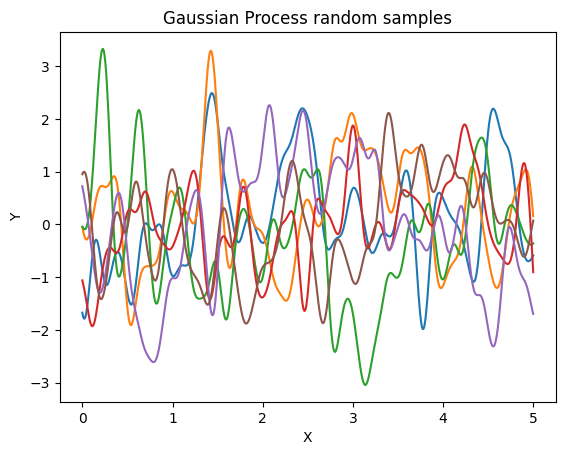

In [8]:
# more than one funciton

def plot_joint_gaussian_samples(D):
#     p = plt.figure()
#     plt.grid(linestyle='--')
    xs = np.linspace(x_bound[0], x_bound[1], D)
    ys_list = []
    ys_dict = []
    for color in range(f_num):
        print(color)
        ys = np.random.multivariate_normal(np.zeros(D), k(xs, xs))
        
        f_dict ={}
        for item in zip(xs, ys):
            f_dict[item[0]] = item[1]
        
        ys_dict.append(f_dict)
        ys_list.append(ys)
        plt.plot(xs, ys,'-')
    plt.title( 'Gaussian Process random samples')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.savefig("randomsamples.png")      
    return xs,ys_list,ys_dict

xs,ys_list,ys_dict = plot_joint_gaussian_samples(1001)


In [2]:
# Load the 2D function from the saved file
ys_list = []
ys_dict = []
loaded_Y = np.load('gaussian_process_2dx10.npy')
xs = np.linspace(x_bound[0], x_bound[1], 1001)
for idx in range(loaded_Y.shape[0]):
    ys = loaded_Y[idx, :]
    f_dict ={}
    for item in zip(xs, ys):
        f_dict[item[0]] = item[1]
        
    ys_dict.append(f_dict)
    ys_list.append(ys)
    
# random_integers = random.sample(range(1001), 500)
# print(random_integers)

In [6]:
list_A = [452, 151, 899, 954, 921, 114, 741, 635, 624, 900, 113, 603, 971, 200, 590, 948, 234, 846, 108, 625, 965, 859, 658, 973, 655, 207, 572, 438, 345, 111, 172, 815, 910, 545, 477, 222, 503, 240, 468, 344, 660, 620, 362, 170, 299, 335, 15, 812, 285, 979, 496, 745, 714, 487, 378, 974, 931, 609, 109, 683, 126, 723, 342, 629, 510, 552, 682, 546, 707, 749, 678, 821, 775, 597, 140, 229, 119, 596, 239, 725, 527, 631, 718, 426, 412, 298, 347, 363, 865, 909, 771, 182, 283, 650, 197, 814, 290, 563, 789, 75, 838, 832, 77, 236, 39, 583, 139, 442, 567, 695, 895, 966, 493, 350, 802, 585, 202, 831, 956, 735, 385, 614, 306, 301, 671, 808, 542, 180, 390, 995, 58, 798, 449, 85, 893, 709, 772, 914, 122, 380, 540, 349, 550, 543, 773, 238, 884, 204, 839, 569, 986, 410, 784, 127, 888, 257, 928, 138, 511, 883, 304, 675, 192, 757, 828, 159, 996, 696, 694, 214, 72, 372, 268, 352, 26, 499, 670, 371, 478, 729, 855, 327, 479, 817, 984, 574, 3, 123, 616, 988, 94, 25, 891, 697, 196, 842, 483, 264, 4, 706, 462, 618, 747, 103, 692, 417, 877, 448, 423, 746, 780, 55, 993, 167, 953, 215, 548, 761, 270, 206, 281, 381, 717, 753, 194, 608, 269, 88, 758, 825, 226, 213, 136, 409, 312, 889, 727, 807, 171, 403, 940, 54, 181, 446, 258, 592, 676, 244, 19, 273, 121, 915, 530, 685, 30, 365, 760, 187, 318, 633, 353, 41, 852, 879, 822, 76, 484, 836, 785, 536, 5, 272, 644, 744, 700, 681, 110, 985, 662, 801, 926, 267, 364, 459, 33, 890, 383, 520, 351, 919, 476, 835, 972, 532, 261, 885, 311, 158, 743, 453, 457, 738, 601, 960, 962, 858, 774, 434, 216, 518, 508, 295, 514, 611, 271, 17, 906, 595, 559, 62, 474, 277, 762, 406, 497, 505, 307, 766, 767, 857, 166, 286, 869, 708, 602, 24, 416, 958, 164, 324, 63, 27, 382, 935, 66, 640, 983, 317, 429, 534, 231, 97, 443, 615, 242, 248, 404, 724, 867, 152, 494, 373, 502, 577, 930, 783, 528, 379, 588, 905, 178, 217, 259, 203, 391, 541, 241, 472, 51, 961, 652, 288, 634, 586, 133, 710, 554, 519, 870, 414, 125, 134, 262, 703, 553, 647, 105, 667, 637, 824, 482, 316, 924, 447, 282, 65, 806, 120, 358, 693, 951, 323, 157, 34, 104, 154, 337, 648, 396, 902, 516, 400, 756, 471, 792, 937, 333, 341, 844, 964, 411, 38, 925, 687, 517, 811, 894, 874, 131, 711, 2, 106, 571, 78, 329, 734, 537, 418, 37, 356, 50, 901, 641, 668, 504, 48, 305, 98, 246, 819, 393, 357, 575, 551, 557, 153, 420, 829, 491, 9, 786, 142, 913, 205, 224, 219, 183, 686, 280, 8, 427, 18, 137, 982, 997, 957, 752, 149, 147, 173, 911, 790, 485, 535, 556, 161, 941, 860, 130, 887] # 你的现有列表A

list_B = [x for x in range(1001) if x not in list_A]
random_integers = list_B
print(len(random_integers))

501


In [13]:
'''
Runing this cell to generate ds_num of PI expert trajectories
If you want to switch to other Acquisition Function,
Modifing the code:
    x_plus, mu_s, sigma_s, std_s, phi, max_at = PI_function(x_obs_1, y_obs_1, x_s, xi)

'''

for ind in range(ds_num):    
    trajectory_idx = ind
    x_obs = []
    y_obs = []
    y_s = ys_list[trajectory_idx]
    x_s = xs
    f = ys_dict[trajectory_idx]
    phi_list = []
    mu_list = []
    sigma_list = []
    max_at_list = []

    first_index_list = random.sample(range(0, len(x_s) - 1), 1)
    x_obs = [x_s[first_index] for first_index in first_index_list]
    y_obs = [y_s[first_index] for first_index in first_index_list]

#     mu_s, Sigma_s, std_s = gpr(x_obs, y_obs, x_s)
#     plt.plot(x_s, y_s, label = 'groundtruth')
#     plt.scatter(x_obs, y_obs, label = 'observations')
#     plt.plot(x_s, mu_s, label= 'best estimate')
#     c = 1.96  # for confidence interval
#     plt.fill_between(x_s, mu_s - c * std_s, mu_s + c * std_s, color='gray', alpha=0.2, label="95% confidence interval")
#     plt.legend()
#     plt.show()

    # probability of improvement
    x_obs_1, y_obs_1 = x_obs, y_obs
    mse_list = []
    
    for i in range(iteration):
#         x_plus, mu_s, sigma_s, std_s = PI_function(x_obs_1, y_obs_1, x_s, xi)
#         xi = random.uniform(0.05, 1)
        x_plus, mu_s, sigma_s, std_s, phi, max_at = PI_function(x_obs_1, y_obs_1, x_s, xi)

        y_plus = f[x_plus]
        x_obs_1=np.append(x_obs_1, x_plus)
        y_obs_1=np.append(y_obs_1, y_plus)
        mse = mean_squared_error(y_s,mu_s)
        
#         print(len(phi),len(mu_s),len(sigma_s))
        
        mse_list.append(mse)
        phi_list.append(phi.tolist())
        mu_list.append(mu_s.tolist())
        sigma_list.append(sigma_s.tolist())
        max_at_list=np.append(max_at_list, max_at)

#         plt.plot(x_s, y_s, label = 'groundtruth')
#         plt.scatter(x_obs_1, y_obs_1, label = 'observations',c='b')
#         plt.plot(x_s, mu_s, label= 'best estimate')
#         plt.plot(x_s, phi, label = 'phi')
#         c = 1.96  # for confidence interval
#         plt.fill_between(x_s, mu_s - c * std_s, mu_s + c * std_s, color='gray', alpha=0.2, label="95% confidence interval")
#         plt.scatter(x_plus, y_plus, label = 'new_observations',c='y')
#         plt.legend()
#         plt.title( 'PI data No.'+str(i))
#         plt.show()
#         print('MSE list:', mse_list)

    

    suffix = 0
    json_name = str(ind+suffix)
    json_name = save_path + '\\'+ json_name + ".json"
    
    
    
    PI =  {'x_obs': x_obs_1.tolist(), 'y_obs':y_obs_1.tolist(), 'phi':phi_list, 'mu':mu_list, 'std':sigma_list, 'max_at':max_at_list.tolist()}
    
    data = {'xs': x_s.tolist(), 'ys': y_s.tolist(), 'PI': PI, 'trajectory_idx':trajectory_idx}

    # 将字典保存到 JSON 文件中
    with open(json_name, 'w') as f:
        json.dump(data, f)

In [8]:
'''
Runing this cell to generate ds_num of randomly selected trajectories
'''

for ind in range(ds_num,2*ds_num):    
    x_obs = []
    y_obs = []
    y_s = ys_list[ind%f_num]
    x_s = xs
    f = ys_dict[ind%f_num]
    phi_list = []
    mu_list = []
    sigma_list = []
    max_at_list = []

    first_index_list = random.sample(range(0, len(x_s) - 1), 1)
    x_obs = [x_s[first_index] for first_index in first_index_list]
    y_obs = [y_s[first_index] for first_index in first_index_list]

#     mu_s, Sigma_s, std_s = gpr(x_obs, y_obs, x_s)
#     plt.plot(x_s, y_s, label = 'groundtruth')
#     plt.scatter(x_obs, y_obs, label = 'observations')
#     plt.plot(x_s, mu_s, label= 'best estimate')
#     c = 1.96  # for confidence interval
#     plt.fill_between(x_s, mu_s - c * std_s, mu_s + c * std_s, color='gray', alpha=0.2, label="95% confidence interval")
#     plt.legend()
#     plt.show()

    # probability of improvement
    x_obs_1, y_obs_1 = x_obs, y_obs
    mse_list = []
    
    for i in range(iteration):
        mu_s, sigma_s, std_s = gpr(x_obs_1, y_obs_1, x_s)
        max_at = random.randint(0, len(x_s) - 1)


        x_plus = x_s[max_at]
        y_plus = y_s[max_at]
        x_obs_1=np.append(x_obs_1, x_plus)
        y_obs_1=np.append(y_obs_1, y_plus)
#         mse = mean_squared_error(y_s,mu_s)
        if np.any(np.isnan(sigma_s)) or np.any(np.isnan(mu_s)):
            print(json_name, '!!! mu/sigma have nan value')
        if y_plus != f[x_plus]:
            print(json_name, '!!! function map error')
        
#         print(len(phi),len(mu_s),len(sigma_s))
        
        mse_list.append(mse)
#         phi_list.append(phi.tolist())
        mu_list.append(mu_s.tolist())
        sigma_list.append(sigma_s.tolist())
        max_at_list=np.append(max_at_list, max_at)

#         plt.plot(x_s, y_s, label = 'groundtruth')
#         plt.scatter(x_obs_1, y_obs_1, label = 'observations',c='b')
#         plt.plot(x_s, mu_s, label= 'best estimate')
#         plt.plot(x_s, phi, label = 'phi')
#         c = 1.96  # for confidence interval
#         plt.fill_between(x_s, mu_s - c * std_s, mu_s + c * std_s, color='gray', alpha=0.2, label="95% confidence interval")
#         plt.scatter(x_plus, y_plus, label = 'new_observations',c='y')
#         plt.legend()
#         plt.title( 'PI data No.'+str(i))
#         plt.show()
#         print('MSE list:', mse_list)

    

    suffix = 25000
    json_name = str(ind+suffix)
    json_name = save_path + '\\'+ json_name + ".json"
    
    
    
    PI =  {'x_obs': x_obs_1.tolist(), 'y_obs':y_obs_1.tolist(), 'mu':mu_list, 'std':sigma_list, 'max_at':max_at_list.tolist()}
    
#     data = {'xs': x_s.tolist(), 'ys': y_s.tolist(), 'PI': PI}
    data = {'xs': x_s.tolist(), 'ys': y_s.tolist(), 'PI': PI}

    #将字典保存到 JSON 文件中
    with open(json_name, 'w') as f:
        json.dump(data, f)